# Давайте посмотрим на результаты

In [1]:
%matplotlib notebook
import os, sys
from matplotlib import pyplot
from sklearn.metrics import roc_curve, roc_auc_score

sys.path.append('/root/cAAE')
from model.tools.config import Config, read_conf
from model.generator import generator, net
# from model.train import train
# from model.test import test, test_show

config = read_conf(f'/root/cAAE/config/{os.environ["CONFIG_NAME"]}.json')
result_list = []

Первым делом получим датасет для теста. Регулируя `config.test.max_batch`, можно менять размер датасета

In [2]:
# config.test.max_batch = 5
dataset = generator(config, train_flg=False)
config.transforms += {'img_shape': dataset.get_img_shape()}

Теперь получим саму сетку (можно изменить в `config.struct.name`). Также можно менять:
* `config.test.thickness` - предполагаемый размер стенки мозга (если 0, то граница вообще не удаляется)
* `config.test.acc` - допустимая ошибка восстановления (от 0 до 1)

In [3]:
config.struct.name = 'AAE'
# config.test.thickness = 2
model_aae = net[config.struct.name](config, train_flg=False)
load_path = '/root/weights'
model_aae.load(load_path)

[Cuda: True]


In [4]:
dst = dataset.to_tensor(tensor=model_aae.Tensor).reshape(-1, model_aae.img_shape[-2], model_aae.img_shape[-1])
dst_mask = dataset.to_tensor(tensor=model_aae.Tensor, type_tr='mask').reshape(-1, model_aae.img_shape[-2], model_aae.img_shape[-1])
dst_tumor = dataset.to_tensor(tensor=model_aae.Tensor, type_tr='tumor').reshape(-1, model_aae.img_shape[-2], model_aae.img_shape[-1])

Download tumor dataset: 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


In [59]:
# result, target = model_res.calc_metric_all(dataset, acc=0.3)
_, restore_tumor = model_aae.recover(dataset, 0.3, dst, dst_mask)
result, target = model_aae.calc_metric(restore_tumor, dst_tumor)
result_list.append([target.cpu(), result.cpu(), model_aae.config.struct.name])

In [20]:
config.struct.name = 'ResDCGAN'
# config.test.metric = 'iou'
model_res = net[config.struct.name](config, train_flg=False)
load_path = '/root/weights'
model_res.load(load_path)
_, restore_tumor = model_res.recover(dataset, 0.3, dst, dst_mask)
result, target = model_res.calc_metric(restore_tumor, dst_tumor)
result_list.append([target.cpu(), result.cpu(), model_aae.config.struct.name])

[Cuda: True]


In [16]:
config.struct.name = 'BiGAN'
# config.test.metric = 'iou'
# config.struct.name = 'AAE'
# config.test.thickness = 2
model_bigan = net[config.struct.name](config, train_flg=False)
load_path = '/root/weights'
model_bigan.load(load_path)
_, restore_tumor = model_bigan.recover(dataset, 0.3, dst, dst_mask)
result, target = model_bigan.calc_metric(restore_tumor, dst_tumor)
result_list.append([target.cpu(), result.cpu(), model_res.config.struct.name])

[Cuda: True]


Строим roc auc. Можно выбрать метрику (`config.test.metric`) между [sd](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) и [iou](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0)

<IPython.core.display.Javascript object>


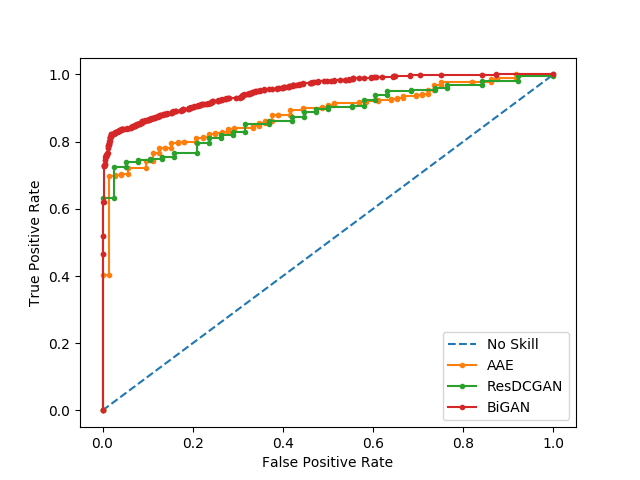

Roc AUC for AAE: 0.8813846526264827
Roc AUC for ResDCGAN: 0.8785213686958911
Roc AUC for BiGAN: 0.9528824961317519


In [66]:
def roc_plot(result_list):
    pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    for target, result, name in result_list:
        target = target[(result>0)]
        result = result[(result>0)]
        result += torch.FloatTensor(np.random.rand(*target.cpu().shape)/3)
        tpr, fpr, _ = roc_curve(target, result)
        print(f'Roc AUC for {name}: {roc_auc_score(target, result)}')
        pyplot.plot(tpr, fpr, marker='.', label=name)
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
roc_plot(result_list)

Теперь можем посмотреть случайные найденные копии

<IPython.core.display.Javascript object>


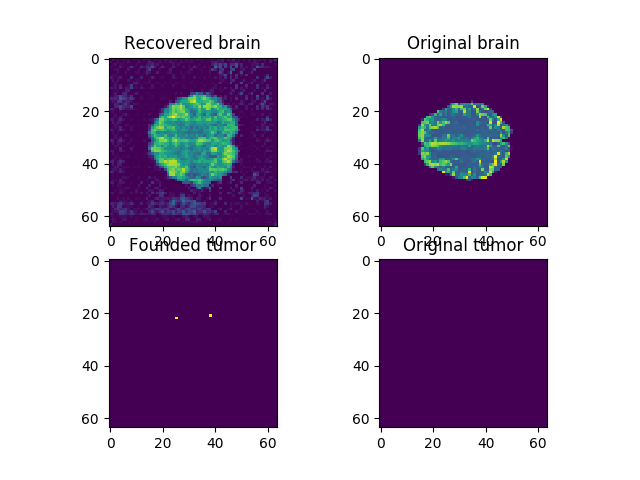

In [24]:
model_res.test_show(dataset, acc=0.3)